In [157]:
import sys
from loadCellsFile import *
from utilities import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import dijkstra
import scipy.io

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, LinearLR
from torch.utils.data import DataLoader
from torch_nl3rSetup import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.decomposition import PCA

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler

In [158]:
# mat = scipy.io.loadmat("./data/jk013_02012023.RRRmdls_forCarlos.mat", simplify_cells=True)["RRRmdls"]
mat = scipy.io.loadmat("./data/jk013_02012023_100ms.timeSeries.cellinfo_forCarlos.mat", simplify_cells=True)

In [159]:
HPC = mat['HPC'].astype("float")
PFC = mat['PFC'].astype("float")

In [160]:
# find trial boundaries
bounds = np.diff((mat['variables']['taskPhase'] != 4).astype('int'))
bounds[0] = 1

starts = np.argwhere(bounds == 1).flatten()
ends = np.argwhere(bounds == -1).flatten()

In [183]:
# extract trials
train_inds = []

trials_HPC = []
trials_PFC = []
for i in range(starts.shape[0]):
    # add trial
    start = starts[i]
    end = ends[i]

    trials_HPC.append(HPC[start:end,:].astype('float'))
    trials_PFC.append(PFC[start:end,:].astype('float'))
    train_inds.append(np.arange(start, end))


    # add ITI
    if (i+1 < starts.shape[0]):
        iti_start = end
        iti_end = starts[i+1]

        trials_HPC.append(HPC[iti_start:iti_end,:].astype('float'))
        trials_PFC.append(PFC[iti_start:iti_end,:].astype('float'))
        train_inds.append(np.arange(iti_start, iti_end))


trials_HPC = np.array(trials_HPC, dtype="object")
trials_PFC = np.array(trials_PFC, dtype="object")
trial_inds = np.array(train_inds, dtype="object")

In [218]:
for i, trial in enumerate(trials_HPC):
    sigmas = np.maximum(1/(trial.mean(axis=0)/.1), .15)/.1
    sigmas[sigmas == np.inf] = trial.shape[0]

    for j in range(trial.shape[1]):
        trial[:, j] = scipy.ndimage.gaussian_filter1d(trial[:,j], sigmas[j], axis=0)

    trials_HPC[i] = trial

for i, trial in enumerate(trials_PFC):
    sigmas = np.maximum(1/(trial.mean(axis=0)/.1), .15)/.1
    sigmas[sigmas == np.inf] = trial.shape[0]

    for j in range(trial.shape[1]):
        trial[:, j] = scipy.ndimage.gaussian_filter1d(trial[:,j], sigmas[j], axis=0)

    trials_PFC[i] = trial

C:\Users\Harris_Lab\AppData\Local\Temp\ipykernel_76756\1473042675.py:2: RuntimeWarning:

divide by zero encountered in divide

C:\Users\Harris_Lab\AppData\Local\Temp\ipykernel_76756\1473042675.py:11: RuntimeWarning:

divide by zero encountered in divide



In [281]:
# calculate and smooth trial averages

HPC_trial_avg = np.zeros((len(trials_HPC), HPC.shape[1]))

for i, rates in enumerate(trials_HPC):
    HPC_trial_avg[i, :] = rates.mean(axis=0)

PFC_trial_avg = np.zeros((len(trials_PFC), PFC.shape[1]))

for i, rates in enumerate(trials_PFC):
    PFC_trial_avg[i, :] = rates.mean(axis=0)

HPC_trial_avg_smooth = scipy.ndimage.gaussian_filter1d(HPC_trial_avg, 10, axis=0)
PFC_trial_avg_smooth = scipy.ndimage.gaussian_filter1d(PFC_trial_avg, 10, axis=0)

In [282]:
HPC_trial_avg.shape

(299, 96)

In [283]:
# correct for slow average
trials_HPC_norm = np.zeros_like(trials_HPC, dtype="object")
trials_PFC_norm = np.zeros_like(trials_PFC, dtype="object")

for i in range(len(trials_HPC)):
    trials_HPC_norm[i] = trials_HPC[i] - HPC_trial_avg_smooth[i]
    trials_PFC_norm[i] = trials_PFC[i] - PFC_trial_avg_smooth[i]

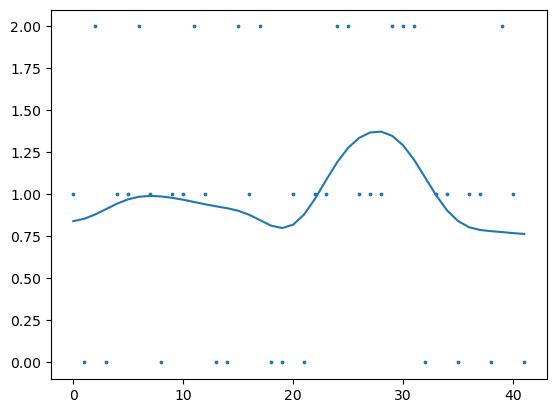

In [284]:
trial = 10
neuron = 50

plt.plot(trials_HPC[trial][:,neuron])
plt.scatter(np.arange(trials_HPC[trial].shape[0]), HPC[trial_inds[trial], neuron], s=3)

In [301]:
# time-stratified train-test split
test_inds = np.arange(0, len(trials_HPC), 8)
train_inds = [ind for ind in np.arange(0, len(trials_HPC)) if (ind not in test_inds)]

HPC_train = np.vstack((trials_HPC_norm[train_inds]))  # type: ignore
HPC_test = np.vstack((trials_HPC_norm[test_inds]))  # type: ignore

PFC_train = np.vstack((trials_PFC_norm[train_inds]))  # type: ignore
PFC_test = np.vstack((trials_PFC_norm[test_inds]))  # type: ignore

var_inds = np.concatenate(trial_inds[train_inds])


In [312]:
mat["variables"].keys()

dict_keys(['position', 'stimulus', 'choice', 'taskPhase', 'performance', 'orientation', 'velocity', 'trialNumbers'])

In [286]:
# PCA
hpc_pca = PCA(n_components=3)
pca_train = hpc_pca.fit_transform(PFC_train)
pca_test = hpc_pca.transform(PFC_test)

df_pca = pd.DataFrame(pca_train)
df_pca.insert(df_pca.shape[1], 'pos', mat['variables']['position'][var_inds])


In [230]:

fig = px.scatter_3d(df_pca, x=0, y=1, z=2,
              color='pos',
              color_continuous_scale=px.colors.sequential.YlOrRd,
              )
fig.update_traces(marker=dict(size=2, opacity=.3),
                  selector=dict(mode='markers'))
fig.show(renderer='browser')

In [231]:
# PCA
hpc_iso = Isomap(n_components=3, n_neighbors=50)
iso_train = hpc_iso.fit_transform(PFC_train)
iso_test = hpc_iso.transform(PFC_test)

df_iso = pd.DataFrame(iso_train)
df_iso.insert(df_iso.shape[1], 'pos', mat['variables']['position'][var_inds])


In [232]:

fig = px.scatter_3d(df_iso, x=0, y=1, z=2,
              color='pos',
              color_continuous_scale=px.colors.sequential.YlOrRd,
              )
fig.update_traces(marker=dict(size=2, opacity=.3),
                  selector=dict(mode='markers'))
fig.show(renderer='browser')

In [168]:
HPC_train.shape

(5797, 96)

In [233]:
# estimate pairwise geodesic dists
neigh = NearestNeighbors(n_neighbors=50, metric='euclidean').fit(HPC_train)
neighbors = neigh.kneighbors(HPC_train, return_distance=False)[:,1:]    # type: ignore
pair_dists = pairwise_distances(HPC_train)
graph = np.zeros_like(pair_dists)

for i in range(pair_dists.shape[0]):
    graph[i, neighbors[i]] = pair_dists[i, neighbors[i]]
x_dists = dijkstra(graph, directed=False)
x_dists = torch.Tensor(x_dists)


In [234]:
# estimate pairwise geodesic dists
neigh = NearestNeighbors(n_neighbors=50, metric='euclidean').fit(PFC_train)
neighbors = neigh.kneighbors(PFC_train, return_distance=False)[:,1:]    # type: ignore
pair_dists = pairwise_distances(PFC_train)
graph = np.zeros_like(pair_dists)

for i in range(pair_dists.shape[0]):
    graph[i, neighbors[i]] = pair_dists[i, neighbors[i]]
y_dists = dijkstra(graph, directed=False)
y_dists = torch.Tensor(y_dists)

x_dists = torch.Tensor(x_dists).to(device)
y_dists = torch.Tensor(y_dists).to(device)

In [302]:
HPC_train = torch.Tensor(HPC_train).to(device)
HPC_test = torch.Tensor(HPC_test).to(device)

PFC_train = torch.Tensor(PFC_train).to(device)
PFC_test = torch.Tensor(PFC_test).to(device)

In [236]:
def carlosPlus(x, logof2):
    return 2*(F.softplus(x) - logof2)

# decoder is the same as encoder but doesn't apply the nonlinearity to the final output
class encoder(nn.Module):
    def __init__(self, nInputs, nOutputs, layers=None, p_drop=0.5, p_input_drop=0.2):
        super(encoder, self).__init__()
        self.layers = nn.ModuleList()
        if layers:
            self.layers.append(nn.Linear(nInputs, layers[0]))
            self.layers.append(nn.Dropout(p=p_drop))
            for i in range(len(layers)-1):
                self.layers.append(nn.Linear(layers[i], layers[i+1]))
                self.layers.append(nn.Dropout(p=p_drop))
            self.layers.append(nn.Linear(layers[-1], nOutputs))
        
    def forward(self, x):
        for layer in self.layers:
            x = carlosPlus(layer(x), np.log(2))
            # x = F.tanh(layer(x))
            # x = F.relu(layer(x))
            # x = layer(x)
        return x
    
class decoder(nn.Module):
    def __init__(self, nInputs, nOutputs, layers=None, p_drop=0.5, p_output_drop=0.2):
        super(decoder, self).__init__()
        self.layers = nn.ModuleList()
        if layers:
            self.layers.append(nn.Linear(nInputs, layers[0]))
            self.layers.append(nn.Dropout(p=p_drop))
            for i in range(len(layers)-1):
                self.layers.append(nn.Linear(layers[i], layers[i+1]))
                self.layers.append(nn.Dropout(p=p_drop))
            self.layers.append(nn.Linear(layers[-1], nOutputs))
        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            # x = layer(x)
            if i == len(self.layers)-1:
                x = layer(x)
            else:
                x = carlosPlus(layer(x), np.log(2))
                # x = F.tanh(layer(x))
                # x = F.relu(layer(x))
        return x

In [237]:
class autoencoder(nn.Module):
    def __init__(self, nInputs, nOutputs, bottleDim, layers=None, p_drop=0.):
        super().__init__()

        self.encoder = encoder(nInputs, bottleDim, layers, p_drop)
        self.decoder = decoder(bottleDim, nOutputs, layers, p_drop)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z
        

In [238]:
def iso_loss_func(target, out, z, dists):
    loss = torch.nn.functional.mse_loss(target, out, reduction='mean')
    # loss = torch.nn.functional.poisson_nll_loss(target, out, reduction='mean')

    prox = torch.linalg.norm(dists-torch.cdist(z,z))/(dists.shape[0]**2)
    return loss + 500*prox, loss, prox    # 50 seems to work well when norm of target frame is ~500x the norm of dists/# of pairs

In [309]:
dims = [1,2,3,4,5,7,10,12,15, 20] #, 30]
pca_train_accs = np.zeros_like(dims, dtype="float32")
pca_test_accs = np.zeros_like(dims, dtype="float32")

for i, dim in enumerate(dims):
    pca = PCA(n_components=dim)

    pca.fit(HPC_train.detach().cpu().numpy())
    rec = torch.Tensor(pca.inverse_transform(pca.transform(HPC_train.detach().cpu().numpy()))).to(device)
    test_rec = torch.Tensor(pca.inverse_transform(pca.transform(HPC_test.detach().cpu().numpy()))).to(device)

    pca_train_accs[i] = torch.nn.functional.mse_loss(rec, HPC_train)
    pca_test_accs[i] = torch.nn.functional.mse_loss(test_rec, HPC_test)

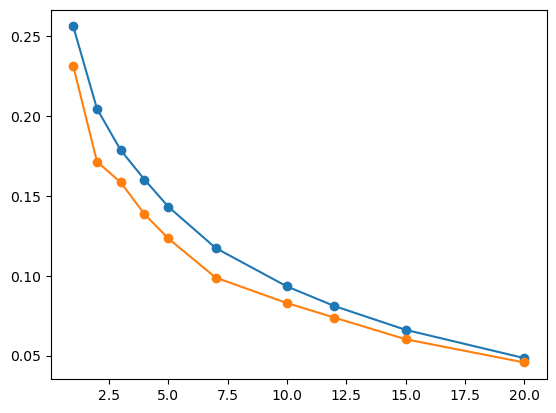

In [310]:
plt.plot(dims, pca_train_accs, marker='o')
plt.plot(dims, pca_test_accs, marker='o')

In [322]:
train_iso_accs = np.ones_like(dims, dtype="float")
iso_proxs = np.ones_like(dims, dtype="float")
test_iso_accs = np.ones_like(dims, dtype="float")


dims = [7]

for i, dim in enumerate(dims):
    min_test = 9999
    # -------------------------- ISOMAP -------------------------------------
    print("---------------- DIM = %d ----------------" % dim)
    lr = 0.001
    num_epochs = 100001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # iso_ce = bottleneck_taper(HPC_train.shape[1], HPC_train.shape[1], dim, base=2).to(device)
    iso_ce = autoencoder(HPC_train.shape[1], HPC_train.shape[1], dim, [200,200,200], p_drop=.3).to(device)

    optimizer = torch.optim.Adam(iso_ce.parameters(), lr=lr)
    scheduler = LinearLR(optimizer, total_iters = 100000, start_factor=1, end_factor=1/50)

    for epoch in range(num_epochs):
        iso_ce.train()
        
        out, z = iso_ce(HPC_train)
        # loss, mse, prox = iso_loss_func(out, HPC_train, z, x_dists)/
        loss = torch.nn.functional.mse_loss(out, HPC_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        iso_ce.eval()
        # if epoch%1000 == 0:
        #     print("Epoch %d | train loss: %.4f | train mse: %.4f | train prox: %.4f | test mse: %.4f" % 
        #         (epoch, 
        #         loss.detach().cpu().numpy(), 
        #         mse.detach().cpu().numpy(), 
        #         prox.detach().cpu().numpy(), 
        #         torch.nn.functional.mse_loss(iso_ce(HPC_test)[0], HPC_test).detach().cpu().numpy()
        #         )
        #     )
        if epoch%1000 == 0:
            print("Epoch %d | train mse: %.4f | test mse: %.4f" % 
                (epoch, 
                loss.detach().cpu().numpy(), 
                torch.nn.functional.mse_loss(iso_ce(HPC_test)[0], HPC_test).detach().cpu().numpy()
                )
            )
        min_test = min(min_test, torch.nn.functional.mse_loss(iso_ce(HPC_test)[0], HPC_test).detach().cpu().numpy())


    train_iso_accs[i] = loss.detach().cpu().numpy()
    test_iso_accs[i] = min_test
    # iso_proxs[i] = prox.detach().cpu().numpy()

---------------- DIM = 7 ----------------
Epoch 0 | train mse: 0.7397 | test mse: 0.2922
Epoch 1000 | train mse: 0.1141 | test mse: 0.0896
Epoch 2000 | train mse: 0.1059 | test mse: 0.0875
Epoch 3000 | train mse: 0.1018 | test mse: 0.0866


KeyboardInterrupt: 

In [324]:
out, z = iso_ce(HPC_test)
s2 = torch.var(HPC_test - out, dim=0).mean()
s1 = torch.var(HPC_test).mean()

print(1-s2/s1)

tensor(0.6293, device='cuda:0', grad_fn=<RsubBackward1>)


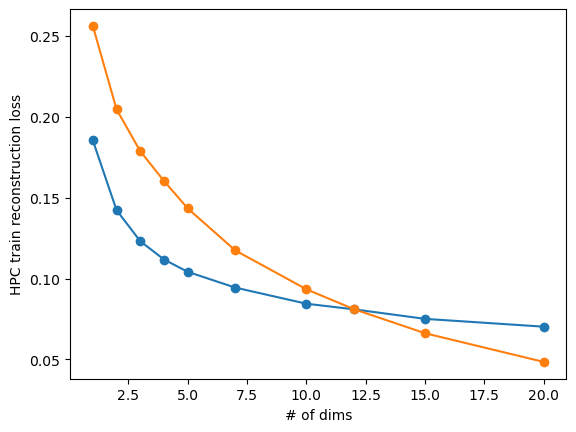

In [ ]:
plt.plot(dims, train_iso_accs, marker='o'); plt.ylabel('HPC train reconstruction loss'); plt.xlabel('# of dims');
# plt.plot(dims[:12], test_iso_accs[:12], marker='o');
plt.plot(dims, pca_train_accs, marker='o')

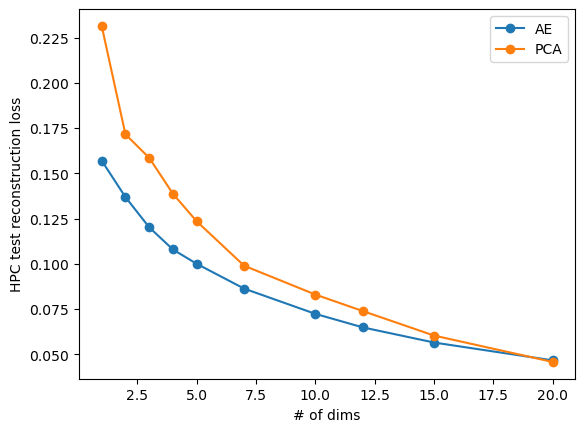

In [314]:
plt.plot(dims, test_iso_accs, marker='o', label="AE"); plt.ylabel('HPC test reconstruction loss'); plt.xlabel('# of dims');
# plt.plot(dims[:12], test_iso_accs[:12], marker='o');
plt.plot(dims, pca_test_accs[:12], marker='o', label="PCA");
plt.legend()

In [244]:
torch.nn.functional.mse_loss(HPC_train.mean(axis=0)*torch.ones_like(HPC_train).to(device), HPC_train).detach().cpu().numpy()

array(0.3264291, dtype=float32)

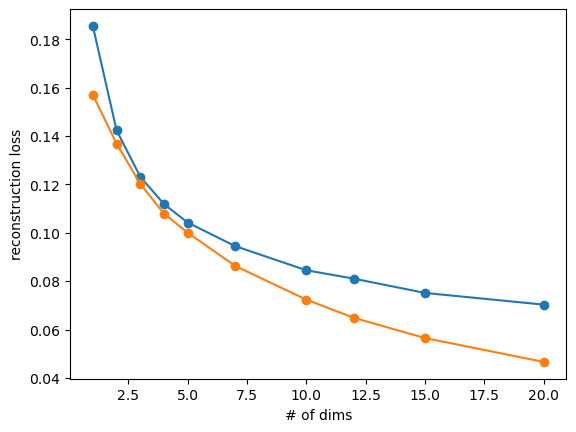

In [315]:
plt.plot(dims, train_iso_accs, marker='o'); plt.ylabel('reconstruction loss'); plt.xlabel('# of dims');
plt.plot(dims, test_iso_accs, marker='o'); plt.ylabel('reconstruction loss'); plt.xlabel('# of dims');


Text(0.5, 0, '# of dims')

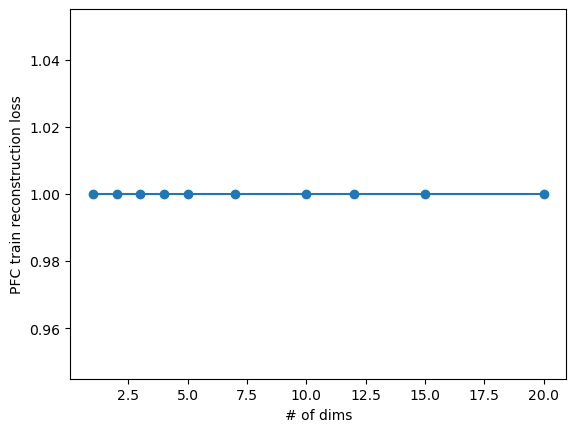

In [182]:
plt.plot(dims, iso_proxs, marker='o'); plt.ylabel('PFC train reconstruction loss'); plt.xlabel('# of dims')

In [289]:
test_out = iso_ce(torch.Tensor(HPC_test).to(device))[0]

In [290]:
train_loss = (out - HPC_train)**2
test_loss = (iso_ce(HPC_test)[0] - HPC_test)**2
# loss = loss.mean(axis=0)
train_loss = train_loss.detach().cpu().numpy()
test_loss = test_loss.detach().cpu().numpy()

In [291]:
train_loss.T.shape

(96, 11903)

In [292]:
# plt.figure(figsize=(20,5))
fig = px.imshow(train_loss[1000:2000].T, width=800, height=800); 
fig.show(renderer="browser")
# plt.colorbar()

In [293]:
train_mean = train_loss.mean(axis=1)
test_mean = test_loss.mean(axis=1)

In [303]:
HPC_test.shape

torch.Size([1842, 96])

In [305]:
np.argwhere(test_mean < thresh)

array([[   6],
       [  36],
       [  37],
       ...,
       [1827],
       [1828],
       [1829]], dtype=int64)

In [298]:
thresh = np.quantile(test_mean, .8)

In [306]:
HPC_test = HPC_test[test_mean < thresh,:]

In [307]:
HPC_test.shape

torch.Size([1473, 96])

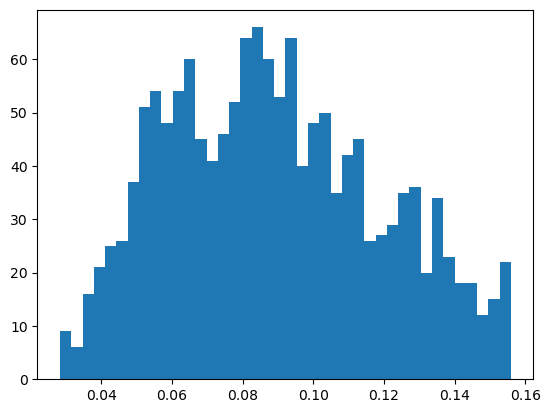

In [308]:
plt.hist(test_mean[test_mean < thresh], bins=40);

(0.0, 0.35)

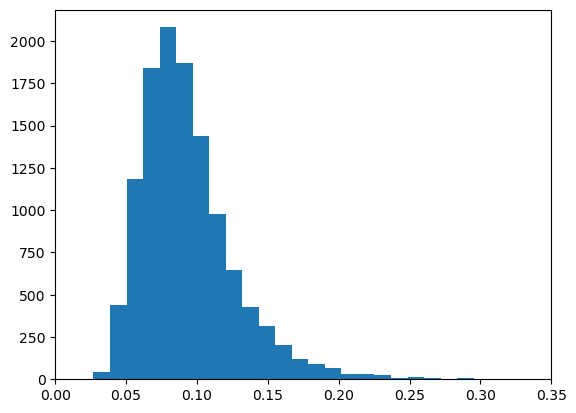

In [296]:
plt.hist(train_mean, bins=180); plt.xlim(0, .35)

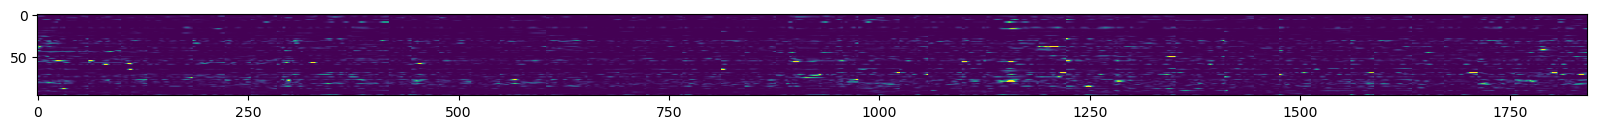

In [297]:
plt.figure(figsize=(20,8))
plt.imshow(test_loss.T, vmin=0, vmax=4); 
# plt.colorbar()

In [254]:
loss.detach().cpu().numpy().argmax()

0

TypeError: len() of unsized object

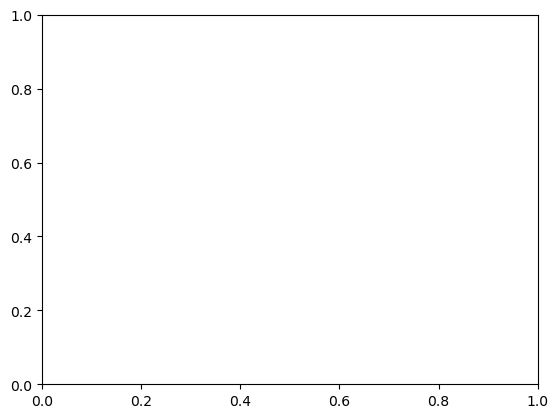

In [255]:
plt.hist(loss.detach().cpu().numpy(), bins=20)

In [256]:
loss.detach().cpu().numpy().argsort()

array([0], dtype=int64)

In [257]:
HPC_train = HPC_train.detach().cpu().numpy()
HPC_test = HPC_test.detach().cpu().numpy()

In [258]:
out.shape

torch.Size([11903, 96])

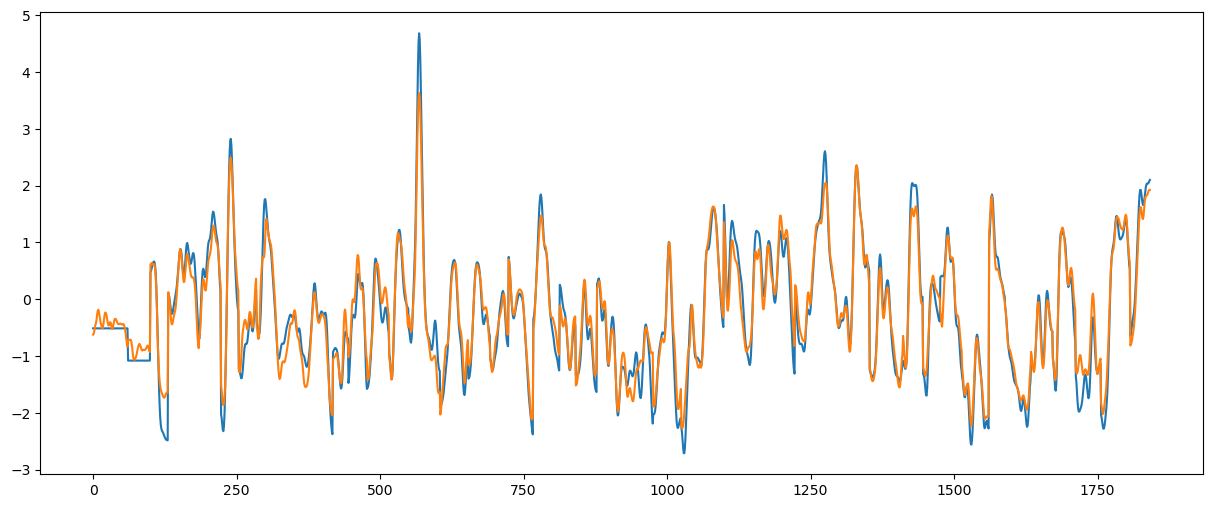

In [264]:
plt.figure(figsize=(15,6))
plt.plot(HPC_test[:,77])
plt.plot(test_out.detach().cpu().numpy()[:,77])

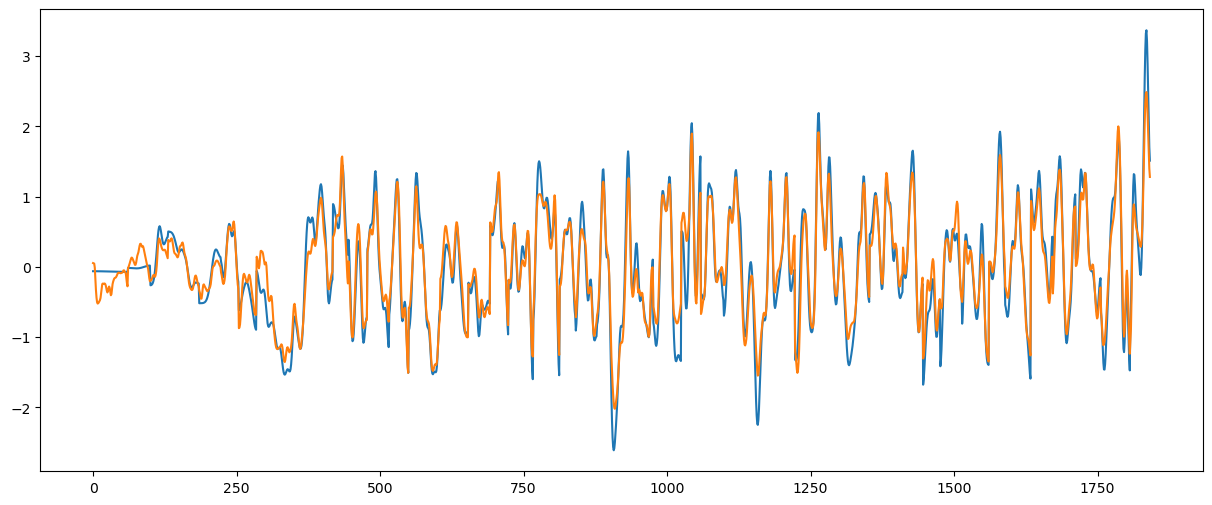

In [265]:
plt.figure(figsize=(15,6))
plt.plot(HPC_test[:,71])
plt.plot(test_out.detach().cpu().numpy()[:,71])

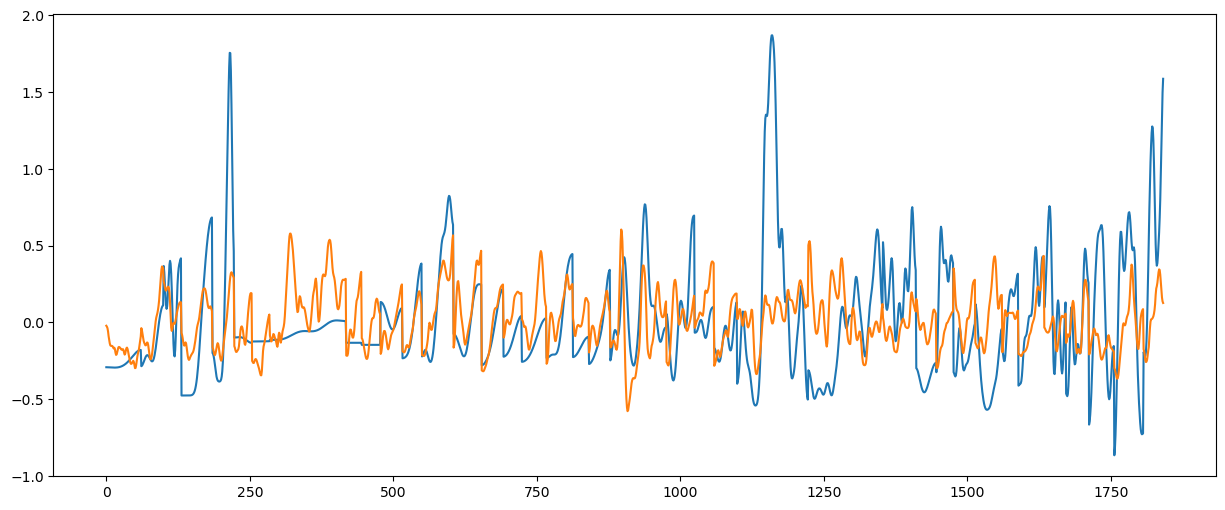

In [266]:
plt.figure(figsize=(15,6))
plt.plot(HPC_test[:,17])
plt.plot(test_out.detach().cpu().numpy()[:,17])

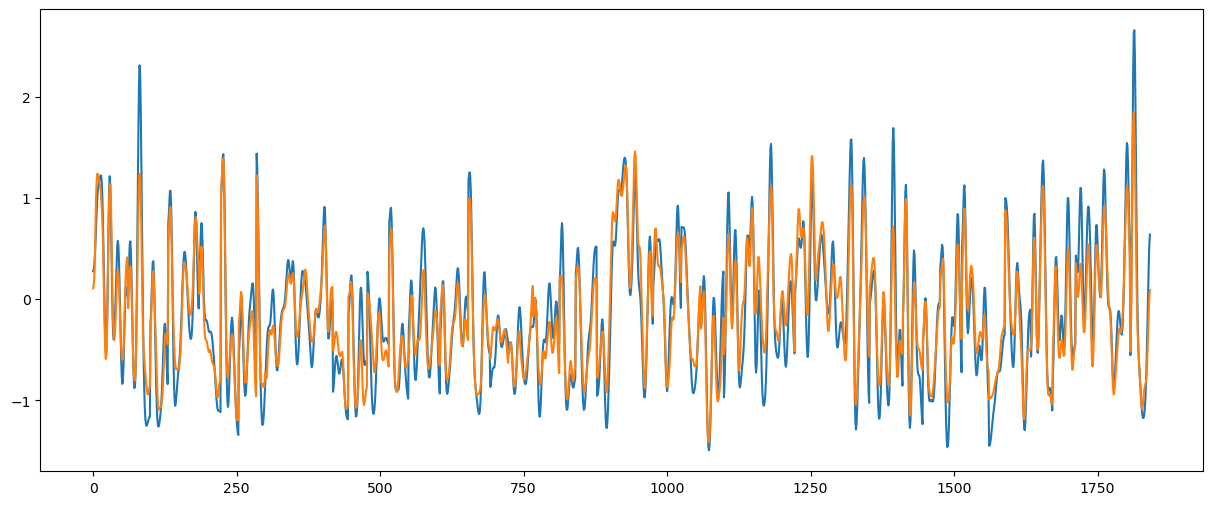

In [267]:
plt.figure(figsize=(15,6))
plt.plot(HPC_test[:,59])
plt.plot(test_out.detach().cpu().numpy()[:,59])

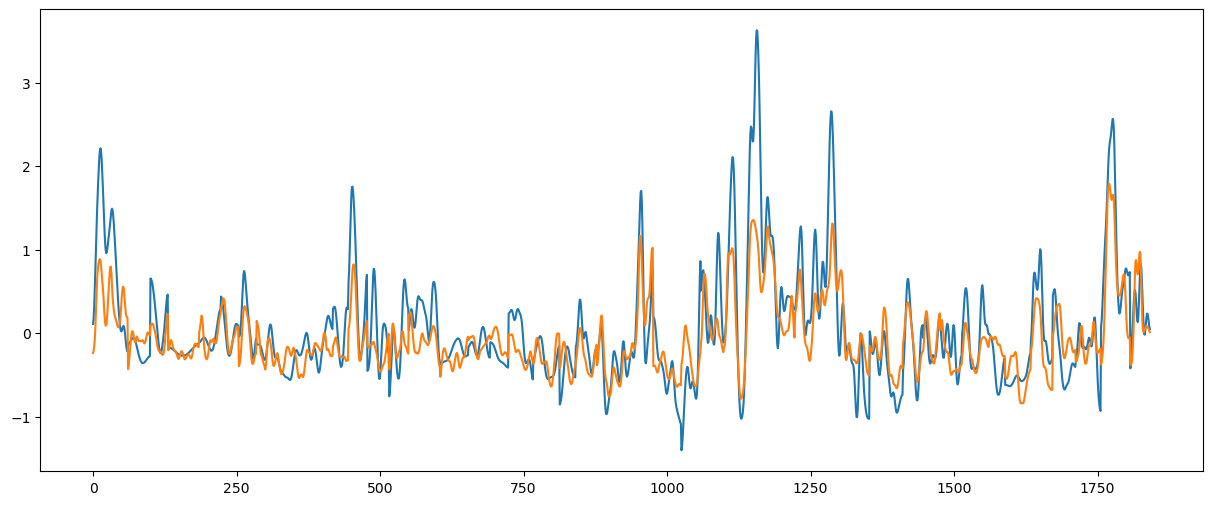

In [268]:
plt.figure(figsize=(15,6))
plt.plot(HPC_test[:,79])
plt.plot(test_out.detach().cpu().numpy()[:,79])

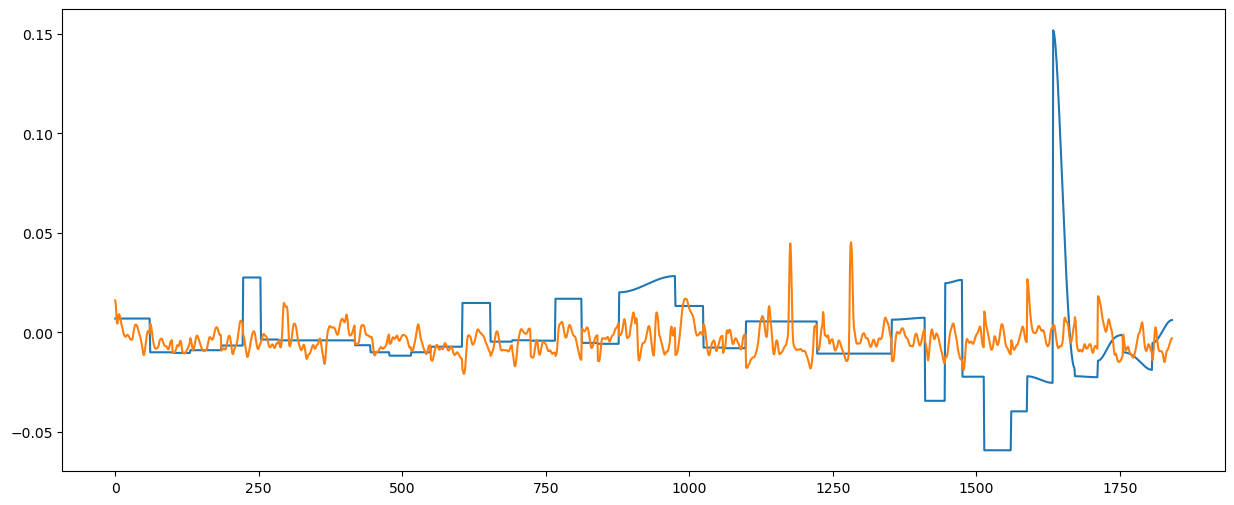

In [270]:
plt.figure(figsize=(15,6))
plt.plot(HPC_test[:,0])
plt.plot(test_out.detach().cpu().numpy()[:,0])

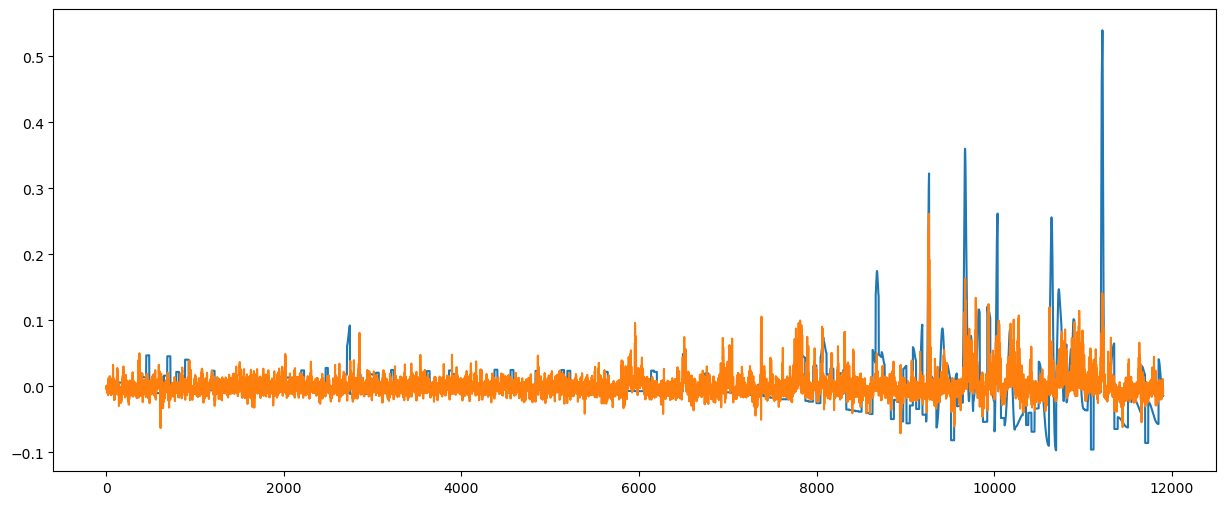

In [271]:
plt.figure(figsize=(15,6))
plt.plot(HPC_train[:,0])
plt.plot(out.detach().cpu().numpy()[:,0])